In [1]:
# !pip install -q torch_fidelity

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Subset
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
from scipy.linalg import sqrtm
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd
from tqdm.auto import tqdm

# Preprocceing and Data loading

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch.manual_seed(42)
np.random.seed(42)

# scale inot 0 and 1
transform = transforms.Compose([
    transforms.ToTensor(),
    lambda x: (x > 0.5).float()
])

full_test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

train_indices = range(0, 1000)
test_indices = range(1000, 2000)


train_dataset = Subset(full_test_dataset, train_indices)
test_dataset = Subset(full_test_dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

def create_flat_tensor_from_loader(loader):
    all_data = []
    for data, _ in loader:
        all_data.append(data)
    flat_tensor = torch.cat(all_data, dim=0)
    return flat_tensor.view(len(loader.dataset), -1).to(device)

X_train = create_flat_tensor_from_loader(train_loader)
X_test = create_flat_tensor_from_loader(test_loader)

print(f"Shape of the flat training tensor: {X_train.shape}")
print(f"Shape of the flat testing tensor: {X_test.shape}")


Using device: cuda


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.60MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.08MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.63MB/s]


Shape of the flat training tensor: torch.Size([1000, 784])
Shape of the flat testing tensor: torch.Size([1000, 784])


# LeNet Training

In [4]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        features = F.relu(self.fc1(x))
        output = self.fc2(features)
        return output, features

In [5]:
# train LeNet on the hole dataset not just the first 1000 smaples of test set.
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

X_test_flat = test_dataset.data.view(len(test_dataset), -1).float() / 255.0
X_test_flat_binarized = (X_test_flat > 0.5).float().to(device)

X_train_flat_binarized = train_dataset.data.view(len(train_dataset), -1).float()
X_train_flat_binarized = (X_train_flat_binarized > 0.5).float()

test_loader_le= DataLoader(test_dataset, batch_size=128, shuffle=False)
train_loader_le = DataLoader(train_dataset, batch_size=128, shuffle=True)


lenet_model = LeNet().to(device)
lenet_optimizer = torch.optim.Adam(lenet_model.parameters(), lr=1e-3)
epochs = 10

lenet_model.train()
for epoch in range(1, epochs + 1):
    for batch_idx, (data, target) in enumerate(tqdm(train_loader_le, desc=f"Epoch {epoch}/{epochs}")):
        data, target = data.to(device), target.to(device)
        lenet_optimizer.zero_grad()
        output, _ = lenet_model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        lenet_optimizer.step()

torch.save(lenet_model.state_dict(), "lenet_mnist.pth")

Epoch 1/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/469 [00:00<?, ?it/s]

In [6]:

lenet_model = LeNet().to(device)
lenet_model.load_state_dict(torch.load("lenet_mnist.pth"))
lenet_model.eval()

def get_features(data, batch_size=128):
    features_list = []
    if len(data.shape) == 2:
        data = data.reshape(-1, 1, 28, 28)

    dataset = TensorDataset(torch.tensor(data).to(device))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    with torch.no_grad():
        for (batch,) in loader:
            _, features = lenet_model(batch)
            features_list.append(features.cpu().numpy())
    return np.concatenate(features_list, axis=0)

def calculate_fid(act1, act2):
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2.0)

    covmean = sqrtm(sigma1.dot(sigma2))

    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

def polynomial_kernel(X, Y):
    d = X.shape[1]
    return (X @ Y.T / d + 1) ** 3

def calculate_kid(act1, act2):
    n1, n2 = act1.shape[0], act2.shape[0]
    K_11 = polynomial_kernel(act1, act1)
    K_22 = polynomial_kernel(act2, act2)
    K_12 = polynomial_kernel(act1, act2)

    mmd2 = (np.sum(K_11) - np.trace(K_11)) / (n1 * (n1 - 1)) + \
           (np.sum(K_22) - np.trace(K_22)) / (n2 * (n2 - 1)) - \
           2 * np.sum(K_12) / (n1 * n2)
    return mmd2

def get_labels_and_probs(data, batch_size=128):
    probs_list = []
    if len(data.shape) == 2:
        data = data.reshape(-1, 1, 28, 28)
    dataset = TensorDataset(torch.tensor(data).to(device))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    with torch.no_grad():
        for (batch,) in loader:
            output, _ = lenet_model(batch)
            probs = F.softmax(output, dim=1).cpu().numpy()
            probs_list.append(probs)
    return np.concatenate(probs_list, axis=0)

def calculate_is_and_diversity(probs):
    kl_divs = probs * (np.log(probs) - np.log(np.mean(probs, axis=0, keepdims=True)))
    kl_divs = np.sum(kl_divs, axis=1)
    is_score = np.exp(np.mean(kl_divs))

    # Diversity (Entropy of marginal label distribution)
    p_y = np.mean(probs, axis=0)
    diversity = -np.sum(p_y * np.log(p_y))

    # Sparsity (KL divergence from uniform distribution)
    uniform_dist = np.full(p_y.shape, 1.0 / len(p_y))
    sparsity = np.sum(p_y * np.log(p_y / uniform_dist))

    return is_score, diversity, sparsity

def plot_samples(samples, title, n_rows=2, n_cols=10):
    samples = samples.reshape(-1, 28, 28)
    plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
    for i in range(min(len(samples), n_rows * n_cols)):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(samples[i], cmap='gray')
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.show()



In [7]:
real_features = get_features(X_test.cpu().numpy())

# VAE Training


In [8]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=256, latent_dim=20):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.input_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def vae_loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def train_vae_with_monitoring(model, optimizer, train_loader, epochs, eval_freq=5, train_losses = []):
    history = []
    model = model.to(device)
    start_time = time.time()

    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats(device)

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        for data, _ in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}", leave=False):
            data = (data > 0.5).float().to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = vae_loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        train_losses.append(total_loss / len(train_loader))
        print(f'Epoch [{epoch}/{epochs}], Loss: {train_losses[-1]:.4f}')

        if epoch % eval_freq == 0 or epoch == epochs:
            model.eval()
            with torch.no_grad():
                z = torch.randn(1000, model.fc_mu.out_features).to(device)
                samples = model.decode(z)
                gen_features = get_features(samples.cpu().numpy())

                fid_score = calculate_fid(real_features, gen_features)
                elapsed_time = time.time() - start_time
                peak_memory_mb = torch.cuda.max_memory_allocated(device) / (1024**2) if torch.cuda.is_available() else 0

                history.append({
                    'epoch': epoch,
                    'time_sec': elapsed_time,
                    'fid': fid_score,
                    'peak_gpu_mem_mb': peak_memory_mb
                })
                print(f"[Epoch {epoch:2d}] Time: {elapsed_time:.1f}s, FID: {fid_score:.2f}, Peak Memory: {peak_memory_mb:.2f} MB")
            model.train()

    return pd.DataFrame(history)


vae_monitored = VAE().to(device)
vae_optimizer_monitored = torch.optim.Adam(vae_monitored.parameters(), lr=1e-3)

train_losses = []

vae_history = train_vae_with_monitoring(
    vae_monitored,
    vae_optimizer_monitored,
    train_loader,
    epochs=100,
    eval_freq=5,
    train_losses = train_losses
)
torch.save(vae_monitored.state_dict(), "vae_mnist.pth")

Epoch 1/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [1/100], Loss: 60946.3057


Epoch 2/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [2/100], Loss: 41578.5708


Epoch 3/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [3/100], Loss: 31906.8154


Epoch 4/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [4/100], Loss: 28524.4646


Epoch 5/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [5/100], Loss: 27107.3784
[Epoch  5] Time: 1.1s, FID: 1113.92, Peak Memory: 84.56 MB


Epoch 6/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [6/100], Loss: 26314.9216


Epoch 7/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [7/100], Loss: 25804.8374


Epoch 8/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [8/100], Loss: 25413.2161


Epoch 9/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [9/100], Loss: 25013.5134


Epoch 10/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [10/100], Loss: 24572.4446
[Epoch 10] Time: 2.1s, FID: 1074.24, Peak Memory: 84.56 MB


Epoch 11/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [11/100], Loss: 24063.6211


Epoch 12/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [12/100], Loss: 23559.3865


Epoch 13/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [13/100], Loss: 23095.0742


Epoch 14/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [14/100], Loss: 22612.0581


Epoch 15/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [15/100], Loss: 22294.6609
[Epoch 15] Time: 3.0s, FID: 953.49, Peak Memory: 85.46 MB


Epoch 16/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [16/100], Loss: 21911.2825


Epoch 17/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [17/100], Loss: 21423.9702


Epoch 18/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [18/100], Loss: 21058.5984


Epoch 19/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [19/100], Loss: 20625.5688


Epoch 20/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [20/100], Loss: 20279.4664
[Epoch 20] Time: 4.1s, FID: 823.26, Peak Memory: 85.46 MB


Epoch 21/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [21/100], Loss: 19885.7822


Epoch 22/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [22/100], Loss: 19550.2322


Epoch 23/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [23/100], Loss: 19249.4087


Epoch 24/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [24/100], Loss: 18982.2219


Epoch 25/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [25/100], Loss: 18763.0872
[Epoch 25] Time: 5.3s, FID: 717.15, Peak Memory: 85.46 MB


Epoch 26/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [26/100], Loss: 18520.2312


Epoch 27/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [27/100], Loss: 18321.2662


Epoch 28/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [28/100], Loss: 18147.1840


Epoch 29/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [29/100], Loss: 17933.6317


Epoch 30/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [30/100], Loss: 17758.8113
[Epoch 30] Time: 6.4s, FID: 648.46, Peak Memory: 85.46 MB


Epoch 31/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [31/100], Loss: 17674.7308


Epoch 32/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [32/100], Loss: 17503.6173


Epoch 33/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [33/100], Loss: 17341.1228


Epoch 34/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [34/100], Loss: 17206.9363


Epoch 35/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [35/100], Loss: 17100.7072
[Epoch 35] Time: 7.3s, FID: 587.44, Peak Memory: 85.46 MB


Epoch 36/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [36/100], Loss: 16930.0570


Epoch 37/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [37/100], Loss: 16746.4608


Epoch 38/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [38/100], Loss: 16667.8550


Epoch 39/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [39/100], Loss: 16528.4878


Epoch 40/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [40/100], Loss: 16383.1412
[Epoch 40] Time: 8.2s, FID: 550.03, Peak Memory: 85.46 MB


Epoch 41/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [41/100], Loss: 16247.4874


Epoch 42/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [42/100], Loss: 16105.2650


Epoch 43/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [43/100], Loss: 16052.6990


Epoch 44/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [44/100], Loss: 15853.8035


Epoch 45/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [45/100], Loss: 15755.7181
[Epoch 45] Time: 9.1s, FID: 492.82, Peak Memory: 85.46 MB


Epoch 46/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [46/100], Loss: 15706.5795


Epoch 47/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [47/100], Loss: 15571.8438


Epoch 48/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [48/100], Loss: 15469.8536


Epoch 49/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [49/100], Loss: 15361.1907


Epoch 50/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [50/100], Loss: 15236.5391
[Epoch 50] Time: 10.1s, FID: 458.07, Peak Memory: 85.46 MB


Epoch 51/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [51/100], Loss: 15154.0930


Epoch 52/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [52/100], Loss: 15058.1366


Epoch 53/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [53/100], Loss: 15017.5929


Epoch 54/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [54/100], Loss: 14868.6233


Epoch 55/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [55/100], Loss: 14738.4313
[Epoch 55] Time: 11.0s, FID: 420.94, Peak Memory: 85.46 MB


Epoch 56/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [56/100], Loss: 14687.5194


Epoch 57/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [57/100], Loss: 14573.8704


Epoch 58/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [58/100], Loss: 14508.5092


Epoch 59/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [59/100], Loss: 14423.7109


Epoch 60/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [60/100], Loss: 14346.9562
[Epoch 60] Time: 12.0s, FID: 374.33, Peak Memory: 85.46 MB


Epoch 61/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [61/100], Loss: 14303.1332


Epoch 62/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [62/100], Loss: 14202.1605


Epoch 63/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [63/100], Loss: 14062.9376


Epoch 64/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [64/100], Loss: 14047.8618


Epoch 65/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [65/100], Loss: 13962.7190
[Epoch 65] Time: 12.9s, FID: 354.09, Peak Memory: 85.46 MB


Epoch 66/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [66/100], Loss: 13880.3329


Epoch 67/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [67/100], Loss: 13869.0829


Epoch 68/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [68/100], Loss: 13795.5367


Epoch 69/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [69/100], Loss: 13718.3849


Epoch 70/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [70/100], Loss: 13657.4729
[Epoch 70] Time: 13.9s, FID: 348.15, Peak Memory: 85.46 MB


Epoch 71/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [71/100], Loss: 13575.4677


Epoch 72/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [72/100], Loss: 13563.1968


Epoch 73/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [73/100], Loss: 13447.2682


Epoch 74/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [74/100], Loss: 13384.4717


Epoch 75/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [75/100], Loss: 13312.6879
[Epoch 75] Time: 14.9s, FID: 318.94, Peak Memory: 85.46 MB


Epoch 76/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [76/100], Loss: 13288.7689


Epoch 77/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [77/100], Loss: 13230.1891


Epoch 78/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [78/100], Loss: 13184.6576


Epoch 79/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [79/100], Loss: 13146.8280


Epoch 80/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [80/100], Loss: 13077.0974
[Epoch 80] Time: 15.8s, FID: 312.74, Peak Memory: 85.46 MB


Epoch 81/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [81/100], Loss: 13015.0873


Epoch 82/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [82/100], Loss: 12952.0485


Epoch 83/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [83/100], Loss: 12888.9518


Epoch 84/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [84/100], Loss: 12829.4789


Epoch 85/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [85/100], Loss: 12779.5737
[Epoch 85] Time: 17.1s, FID: 285.46, Peak Memory: 85.46 MB


Epoch 86/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [86/100], Loss: 12696.7747


Epoch 87/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [87/100], Loss: 12676.1525


Epoch 88/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [88/100], Loss: 12609.2278


Epoch 89/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [89/100], Loss: 12570.0991


Epoch 90/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [90/100], Loss: 12530.4014
[Epoch 90] Time: 18.4s, FID: 288.41, Peak Memory: 85.46 MB


Epoch 91/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [91/100], Loss: 12512.8959


Epoch 92/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [92/100], Loss: 12455.2231


Epoch 93/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [93/100], Loss: 12383.1302


Epoch 94/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [94/100], Loss: 12354.0984


Epoch 95/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [95/100], Loss: 12292.3848
[Epoch 95] Time: 19.4s, FID: 278.19, Peak Memory: 85.46 MB


Epoch 96/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [96/100], Loss: 12226.2816


Epoch 97/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [97/100], Loss: 12198.2164


Epoch 98/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [98/100], Loss: 12158.4109


Epoch 99/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [99/100], Loss: 12117.9161


Epoch 100/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [100/100], Loss: 12103.3192
[Epoch 100] Time: 20.4s, FID: 256.26, Peak Memory: 85.46 MB


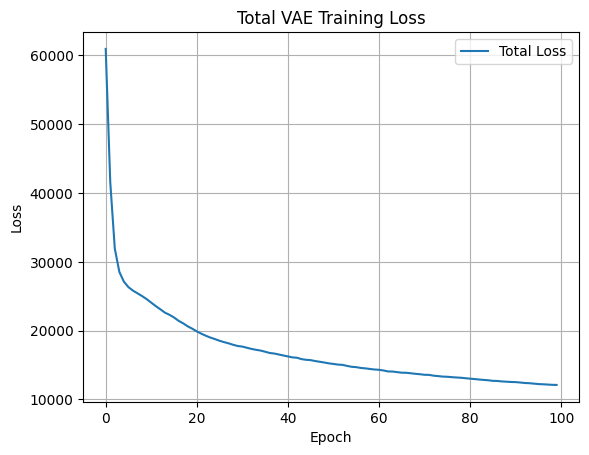

In [9]:
plt.plot(train_losses, label='Total Loss')
plt.title('Total VAE Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()

In [10]:
torch.save(vae_monitored.state_dict(), "vae_mnist.pth")

# NADE Training

i train the NADE model more than 100 epochs but it starts to overfit, so the best choice was training 100 epochs.

In [11]:

class NADE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=500):
        super(NADE, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):

        x_logits = torch.zeros_like(x)
        for i in range(self.input_dim):

            x_masked = x.clone()
            x_masked[:, i:] = 0
            h = torch.relu(self.fc1(x_masked))

            x_logits[:, i] = self.fc2(h)[:, i]
        return x_logits

    def log_prob(self, x):
      logits = self.forward(x)
      return -F.binary_cross_entropy_with_logits(logits, x, reduction='none').sum(dim=1)

    def sample(self, n_samples):
        self.eval()
        samples = torch.zeros(n_samples, self.input_dim).to(device)
        with torch.no_grad():
            for i in tqdm(range(self.input_dim), desc="NADE Sampling"):
                h = torch.relu(self.fc1(samples))
                out_logits = self.fc2(h)

                pixel_probs = torch.sigmoid(out_logits[:, i])

                pixel_sample = torch.bernoulli(pixel_probs)
                samples[:, i] = pixel_sample
        return samples

def train_nade_with_monitoring(model, optimizer, train_loader, test_loader, epochs, eval_freq=5, train_losses = [], test_losses = []):
    history = []

    model = model.to(device)
    start_time = time.time()

    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats(device)

    print("--- Starting NADE Training with Monitoring ---")
    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0
        for (data,) in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}", leave=False):
            data = data.view(-1, 784).to(device)
            optimizer.zero_grad()
            loss = -model.log_prob(data).mean()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)


        model.eval()
        with torch.no_grad():
            test_loss = 0
            for (batch,) in test_loader:
                batch = batch.view(-1, 784).to(device)
                test_loss += -model.log_prob(batch).mean()

            avg_test_loss = test_loss / len(test_loader)
            test_losses.append(avg_test_loss)

        print(f"{epoch}, training_loss = {avg_train_loss}, test_loss = {avg_test_loss}")


        if epoch % eval_freq == 0 or epoch == epochs:

            print(f"Epoch {epoch}: Generating samples for FID calculation.")
            samples = model.sample(1000)
            gen_features = get_features(samples.cpu().numpy())

            fid_score = calculate_fid(real_features, gen_features)
            elapsed_time = time.time() - start_time
            peak_memory_mb = torch.cuda.max_memory_allocated(device) / (1024**2) if torch.cuda.is_available() else 0


            history.append({
                'epoch': epoch,
                'time_sec': elapsed_time,
                'fid': fid_score,
                'peak_gpu_mem_mb': peak_memory_mb
            })
            print(f"[Epoch {epoch:2d}] Time: {elapsed_time:.1f}s, FID: {fid_score:.2f}, Peak Memory: {peak_memory_mb:.2f} MB")

    print("--- NADE Training Complete ---")
    return pd.DataFrame(history)

nade_monitored = NADE().to(device)
nade_optimizer_monitored = torch.optim.Adam(nade_monitored.parameters(), lr=1e-3)

nade_train_loader = DataLoader(TensorDataset(X_train.to(device)), batch_size=128, shuffle=True)
nade_test_loader = DataLoader(TensorDataset(X_test.to(device)), batch_size=128, shuffle=False)

train_losses = []
test_losses = []

nade_history = train_nade_with_monitoring(
    nade_monitored,
    nade_optimizer_monitored,
    nade_train_loader,
    nade_test_loader,
    epochs=100,
    eval_freq=5,
    train_losses = train_losses,
    test_losses = test_losses
)
torch.save(nade_monitored.state_dict(), "nade_mnist.pth")

--- Starting NADE Training with Monitoring ---


Epoch 1/100:   0%|          | 0/8 [00:00<?, ?it/s]

1, training_loss = 483.24279022216797, test_loss = 383.3350830078125


Epoch 2/100:   0%|          | 0/8 [00:00<?, ?it/s]

2, training_loss = 344.77207946777344, test_loss = 311.7894287109375


Epoch 3/100:   0%|          | 0/8 [00:00<?, ?it/s]

3, training_loss = 299.838436126709, test_loss = 282.545166015625


Epoch 4/100:   0%|          | 0/8 [00:00<?, ?it/s]

4, training_loss = 271.37802505493164, test_loss = 255.46847534179688


Epoch 5/100:   0%|          | 0/8 [00:00<?, ?it/s]

5, training_loss = 244.2843723297119, test_loss = 230.08998107910156
Epoch 5: Generating samples for FID calculation.


NADE Sampling:   0%|          | 0/784 [00:00<?, ?it/s]

[Epoch  5] Time: 26.0s, FID: 479.41, Peak Memory: 567.64 MB


Epoch 6/100:   0%|          | 0/8 [00:00<?, ?it/s]

6, training_loss = 218.7651653289795, test_loss = 206.7930450439453


Epoch 7/100:   0%|          | 0/8 [00:00<?, ?it/s]

7, training_loss = 196.32777786254883, test_loss = 187.24960327148438


Epoch 8/100:   0%|          | 0/8 [00:00<?, ?it/s]

8, training_loss = 178.08892440795898, test_loss = 172.44508361816406


Epoch 9/100:   0%|          | 0/8 [00:00<?, ?it/s]

9, training_loss = 164.23382568359375, test_loss = 161.8120880126953


Epoch 10/100:   0%|          | 0/8 [00:00<?, ?it/s]

10, training_loss = 153.9285488128662, test_loss = 153.98219299316406
Epoch 10: Generating samples for FID calculation.


NADE Sampling:   0%|          | 0/784 [00:00<?, ?it/s]

[Epoch 10] Time: 51.8s, FID: 319.20, Peak Memory: 570.63 MB


Epoch 11/100:   0%|          | 0/8 [00:00<?, ?it/s]

11, training_loss = 146.33226013183594, test_loss = 148.140869140625


Epoch 12/100:   0%|          | 0/8 [00:00<?, ?it/s]

12, training_loss = 140.32805252075195, test_loss = 143.29388427734375


Epoch 13/100:   0%|          | 0/8 [00:00<?, ?it/s]

13, training_loss = 135.12061882019043, test_loss = 139.4066619873047


Epoch 14/100:   0%|          | 0/8 [00:00<?, ?it/s]

14, training_loss = 130.81338119506836, test_loss = 136.07937622070312


Epoch 15/100:   0%|          | 0/8 [00:00<?, ?it/s]

15, training_loss = 126.9917106628418, test_loss = 133.17471313476562
Epoch 15: Generating samples for FID calculation.


NADE Sampling:   0%|          | 0/784 [00:00<?, ?it/s]

[Epoch 15] Time: 77.8s, FID: 232.75, Peak Memory: 570.64 MB


Epoch 16/100:   0%|          | 0/8 [00:00<?, ?it/s]

16, training_loss = 123.64842224121094, test_loss = 130.74078369140625


Epoch 17/100:   0%|          | 0/8 [00:00<?, ?it/s]

17, training_loss = 120.59340190887451, test_loss = 128.35330200195312


Epoch 18/100:   0%|          | 0/8 [00:00<?, ?it/s]

18, training_loss = 117.62767791748047, test_loss = 126.21321868896484


Epoch 19/100:   0%|          | 0/8 [00:00<?, ?it/s]

19, training_loss = 114.98794078826904, test_loss = 124.37772369384766


Epoch 20/100:   0%|          | 0/8 [00:00<?, ?it/s]

20, training_loss = 112.54262924194336, test_loss = 122.5203857421875
Epoch 20: Generating samples for FID calculation.


NADE Sampling:   0%|          | 0/784 [00:00<?, ?it/s]

[Epoch 20] Time: 104.0s, FID: 180.06, Peak Memory: 570.64 MB


Epoch 21/100:   0%|          | 0/8 [00:00<?, ?it/s]

21, training_loss = 110.30862426757812, test_loss = 121.02601623535156


Epoch 22/100:   0%|          | 0/8 [00:00<?, ?it/s]

22, training_loss = 108.05278873443604, test_loss = 119.39584350585938


Epoch 23/100:   0%|          | 0/8 [00:00<?, ?it/s]

23, training_loss = 106.16329193115234, test_loss = 117.9093017578125


Epoch 24/100:   0%|          | 0/8 [00:00<?, ?it/s]

24, training_loss = 104.17335319519043, test_loss = 116.72811889648438


Epoch 25/100:   0%|          | 0/8 [00:00<?, ?it/s]

25, training_loss = 102.29610919952393, test_loss = 115.35926818847656
Epoch 25: Generating samples for FID calculation.


NADE Sampling:   0%|          | 0/784 [00:00<?, ?it/s]

[Epoch 25] Time: 134.6s, FID: 147.41, Peak Memory: 570.64 MB


Epoch 26/100:   0%|          | 0/8 [00:00<?, ?it/s]

26, training_loss = 100.44950866699219, test_loss = 114.25499725341797


Epoch 27/100:   0%|          | 0/8 [00:00<?, ?it/s]

27, training_loss = 98.85579299926758, test_loss = 113.08356475830078


Epoch 28/100:   0%|          | 0/8 [00:00<?, ?it/s]

28, training_loss = 97.30720615386963, test_loss = 112.21379089355469


Epoch 29/100:   0%|          | 0/8 [00:00<?, ?it/s]

29, training_loss = 95.5885877609253, test_loss = 111.08351135253906


Epoch 30/100:   0%|          | 0/8 [00:00<?, ?it/s]

30, training_loss = 94.20262908935547, test_loss = 110.11927032470703
Epoch 30: Generating samples for FID calculation.


NADE Sampling:   0%|          | 0/784 [00:00<?, ?it/s]

[Epoch 30] Time: 160.6s, FID: 131.41, Peak Memory: 570.64 MB


Epoch 31/100:   0%|          | 0/8 [00:00<?, ?it/s]

31, training_loss = 92.66411018371582, test_loss = 109.26388549804688


Epoch 32/100:   0%|          | 0/8 [00:00<?, ?it/s]

32, training_loss = 91.43627834320068, test_loss = 108.52534484863281


Epoch 33/100:   0%|          | 0/8 [00:00<?, ?it/s]

33, training_loss = 90.1890230178833, test_loss = 107.75125122070312


Epoch 34/100:   0%|          | 0/8 [00:00<?, ?it/s]

34, training_loss = 88.96266269683838, test_loss = 107.08267974853516


Epoch 35/100:   0%|          | 0/8 [00:00<?, ?it/s]

35, training_loss = 87.69476985931396, test_loss = 106.3699951171875
Epoch 35: Generating samples for FID calculation.


NADE Sampling:   0%|          | 0/784 [00:00<?, ?it/s]

[Epoch 35] Time: 187.1s, FID: 114.48, Peak Memory: 570.65 MB


Epoch 36/100:   0%|          | 0/8 [00:00<?, ?it/s]

36, training_loss = 86.54368495941162, test_loss = 105.90621948242188


Epoch 37/100:   0%|          | 0/8 [00:00<?, ?it/s]

37, training_loss = 85.4014081954956, test_loss = 105.08770751953125


Epoch 38/100:   0%|          | 0/8 [00:00<?, ?it/s]

38, training_loss = 84.36992454528809, test_loss = 104.55895233154297


Epoch 39/100:   0%|          | 0/8 [00:00<?, ?it/s]

39, training_loss = 83.28518581390381, test_loss = 104.01097106933594


Epoch 40/100:   0%|          | 0/8 [00:00<?, ?it/s]

40, training_loss = 82.24410438537598, test_loss = 103.6288833618164
Epoch 40: Generating samples for FID calculation.


NADE Sampling:   0%|          | 0/784 [00:00<?, ?it/s]

[Epoch 40] Time: 213.3s, FID: 100.66, Peak Memory: 570.65 MB


Epoch 41/100:   0%|          | 0/8 [00:00<?, ?it/s]

41, training_loss = 81.34030723571777, test_loss = 103.04268646240234


Epoch 42/100:   0%|          | 0/8 [00:00<?, ?it/s]

42, training_loss = 80.40754127502441, test_loss = 102.68156433105469


Epoch 43/100:   0%|          | 0/8 [00:00<?, ?it/s]

43, training_loss = 79.50373268127441, test_loss = 102.2224349975586


Epoch 44/100:   0%|          | 0/8 [00:00<?, ?it/s]

44, training_loss = 78.63473224639893, test_loss = 101.85624694824219


Epoch 45/100:   0%|          | 0/8 [00:00<?, ?it/s]

45, training_loss = 77.80488395690918, test_loss = 101.42872619628906
Epoch 45: Generating samples for FID calculation.


NADE Sampling:   0%|          | 0/784 [00:00<?, ?it/s]

[Epoch 45] Time: 239.8s, FID: 98.12, Peak Memory: 570.65 MB


Epoch 46/100:   0%|          | 0/8 [00:00<?, ?it/s]

46, training_loss = 76.95150661468506, test_loss = 101.25511169433594


Epoch 47/100:   0%|          | 0/8 [00:00<?, ?it/s]

47, training_loss = 76.30416202545166, test_loss = 100.79174041748047


Epoch 48/100:   0%|          | 0/8 [00:00<?, ?it/s]

48, training_loss = 75.37260913848877, test_loss = 100.50545501708984


Epoch 49/100:   0%|          | 0/8 [00:00<?, ?it/s]

49, training_loss = 74.59619522094727, test_loss = 100.14037322998047


Epoch 50/100:   0%|          | 0/8 [00:00<?, ?it/s]

50, training_loss = 73.82388210296631, test_loss = 99.8536148071289
Epoch 50: Generating samples for FID calculation.


NADE Sampling:   0%|          | 0/784 [00:00<?, ?it/s]

[Epoch 50] Time: 265.6s, FID: 92.01, Peak Memory: 570.65 MB


Epoch 51/100:   0%|          | 0/8 [00:00<?, ?it/s]

51, training_loss = 73.09083652496338, test_loss = 99.5851058959961


Epoch 52/100:   0%|          | 0/8 [00:00<?, ?it/s]

52, training_loss = 72.42138957977295, test_loss = 99.40486907958984


Epoch 53/100:   0%|          | 0/8 [00:00<?, ?it/s]

53, training_loss = 71.76637744903564, test_loss = 99.30422973632812


Epoch 54/100:   0%|          | 0/8 [00:00<?, ?it/s]

54, training_loss = 71.0792007446289, test_loss = 98.89716339111328


Epoch 55/100:   0%|          | 0/8 [00:00<?, ?it/s]

55, training_loss = 70.4609842300415, test_loss = 98.74253845214844
Epoch 55: Generating samples for FID calculation.


NADE Sampling:   0%|          | 0/784 [00:00<?, ?it/s]

[Epoch 55] Time: 291.6s, FID: 90.09, Peak Memory: 570.66 MB


Epoch 56/100:   0%|          | 0/8 [00:00<?, ?it/s]

56, training_loss = 69.76620769500732, test_loss = 98.46015930175781


Epoch 57/100:   0%|          | 0/8 [00:00<?, ?it/s]

57, training_loss = 69.13773727416992, test_loss = 98.40933227539062


Epoch 58/100:   0%|          | 0/8 [00:00<?, ?it/s]

58, training_loss = 68.48843574523926, test_loss = 98.17472839355469


Epoch 59/100:   0%|          | 0/8 [00:00<?, ?it/s]

59, training_loss = 67.96525859832764, test_loss = 98.01077270507812


Epoch 60/100:   0%|          | 0/8 [00:00<?, ?it/s]

60, training_loss = 67.42595863342285, test_loss = 97.90139770507812
Epoch 60: Generating samples for FID calculation.


NADE Sampling:   0%|          | 0/784 [00:00<?, ?it/s]

[Epoch 60] Time: 317.6s, FID: 90.70, Peak Memory: 570.66 MB


Epoch 61/100:   0%|          | 0/8 [00:00<?, ?it/s]

61, training_loss = 66.75939559936523, test_loss = 97.7801284790039


Epoch 62/100:   0%|          | 0/8 [00:00<?, ?it/s]

62, training_loss = 66.1887435913086, test_loss = 97.63633728027344


Epoch 63/100:   0%|          | 0/8 [00:00<?, ?it/s]

63, training_loss = 65.66372013092041, test_loss = 97.58101654052734


Epoch 64/100:   0%|          | 0/8 [00:00<?, ?it/s]

64, training_loss = 65.15656471252441, test_loss = 97.38699340820312


Epoch 65/100:   0%|          | 0/8 [00:00<?, ?it/s]

65, training_loss = 64.6077561378479, test_loss = 97.31465148925781
Epoch 65: Generating samples for FID calculation.


NADE Sampling:   0%|          | 0/784 [00:00<?, ?it/s]

[Epoch 65] Time: 343.9s, FID: 80.71, Peak Memory: 570.66 MB


Epoch 66/100:   0%|          | 0/8 [00:00<?, ?it/s]

66, training_loss = 64.05484390258789, test_loss = 97.2739486694336


Epoch 67/100:   0%|          | 0/8 [00:00<?, ?it/s]

67, training_loss = 63.59080410003662, test_loss = 97.22357177734375


Epoch 68/100:   0%|          | 0/8 [00:00<?, ?it/s]

68, training_loss = 63.0147590637207, test_loss = 97.04074096679688


Epoch 69/100:   0%|          | 0/8 [00:00<?, ?it/s]

69, training_loss = 62.57980394363403, test_loss = 97.04438781738281


Epoch 70/100:   0%|          | 0/8 [00:00<?, ?it/s]

70, training_loss = 62.043203353881836, test_loss = 97.06803894042969
Epoch 70: Generating samples for FID calculation.


NADE Sampling:   0%|          | 0/784 [00:00<?, ?it/s]

[Epoch 70] Time: 370.0s, FID: 78.02, Peak Memory: 570.66 MB


Epoch 71/100:   0%|          | 0/8 [00:00<?, ?it/s]

71, training_loss = 61.62144184112549, test_loss = 96.91522979736328


Epoch 72/100:   0%|          | 0/8 [00:00<?, ?it/s]

72, training_loss = 61.07520055770874, test_loss = 96.93402862548828


Epoch 73/100:   0%|          | 0/8 [00:00<?, ?it/s]

73, training_loss = 60.64757680892944, test_loss = 96.96167755126953


Epoch 74/100:   0%|          | 0/8 [00:00<?, ?it/s]

74, training_loss = 60.24036264419556, test_loss = 96.91190338134766


Epoch 75/100:   0%|          | 0/8 [00:00<?, ?it/s]

75, training_loss = 59.79636096954346, test_loss = 96.80973052978516
Epoch 75: Generating samples for FID calculation.


NADE Sampling:   0%|          | 0/784 [00:00<?, ?it/s]

[Epoch 75] Time: 396.5s, FID: 72.77, Peak Memory: 570.67 MB


Epoch 76/100:   0%|          | 0/8 [00:00<?, ?it/s]

76, training_loss = 59.26467037200928, test_loss = 96.95182800292969


Epoch 77/100:   0%|          | 0/8 [00:00<?, ?it/s]

77, training_loss = 58.88396120071411, test_loss = 96.77986145019531


Epoch 78/100:   0%|          | 0/8 [00:00<?, ?it/s]

78, training_loss = 58.47601890563965, test_loss = 96.94436645507812


Epoch 79/100:   0%|          | 0/8 [00:00<?, ?it/s]

79, training_loss = 58.073413372039795, test_loss = 96.84623718261719


Epoch 80/100:   0%|          | 0/8 [00:00<?, ?it/s]

80, training_loss = 57.69709300994873, test_loss = 96.81285095214844
Epoch 80: Generating samples for FID calculation.


NADE Sampling:   0%|          | 0/784 [00:00<?, ?it/s]

[Epoch 80] Time: 422.4s, FID: 76.91, Peak Memory: 570.67 MB


Epoch 81/100:   0%|          | 0/8 [00:00<?, ?it/s]

81, training_loss = 57.23665237426758, test_loss = 96.9713363647461


Epoch 82/100:   0%|          | 0/8 [00:00<?, ?it/s]

82, training_loss = 56.90591621398926, test_loss = 96.93866729736328


Epoch 83/100:   0%|          | 0/8 [00:00<?, ?it/s]

83, training_loss = 56.473881244659424, test_loss = 97.03683471679688


Epoch 84/100:   0%|          | 0/8 [00:00<?, ?it/s]

84, training_loss = 56.11813163757324, test_loss = 96.99909210205078


Epoch 85/100:   0%|          | 0/8 [00:00<?, ?it/s]

85, training_loss = 55.71251583099365, test_loss = 97.12242126464844
Epoch 85: Generating samples for FID calculation.


NADE Sampling:   0%|          | 0/784 [00:00<?, ?it/s]

[Epoch 85] Time: 448.4s, FID: 67.71, Peak Memory: 570.67 MB


Epoch 86/100:   0%|          | 0/8 [00:00<?, ?it/s]

86, training_loss = 55.26877164840698, test_loss = 96.9658432006836


Epoch 87/100:   0%|          | 0/8 [00:00<?, ?it/s]

87, training_loss = 54.954779624938965, test_loss = 97.19827270507812


Epoch 88/100:   0%|          | 0/8 [00:00<?, ?it/s]

88, training_loss = 54.59681701660156, test_loss = 97.16523742675781


Epoch 89/100:   0%|          | 0/8 [00:00<?, ?it/s]

89, training_loss = 54.23408555984497, test_loss = 97.30365753173828


Epoch 90/100:   0%|          | 0/8 [00:00<?, ?it/s]

90, training_loss = 53.89416837692261, test_loss = 97.2623519897461
Epoch 90: Generating samples for FID calculation.


NADE Sampling:   0%|          | 0/784 [00:00<?, ?it/s]

[Epoch 90] Time: 478.8s, FID: 71.06, Peak Memory: 570.67 MB


Epoch 91/100:   0%|          | 0/8 [00:00<?, ?it/s]

91, training_loss = 53.47392272949219, test_loss = 97.40966796875


Epoch 92/100:   0%|          | 0/8 [00:00<?, ?it/s]

92, training_loss = 53.20083475112915, test_loss = 97.44010162353516


Epoch 93/100:   0%|          | 0/8 [00:00<?, ?it/s]

93, training_loss = 52.80718183517456, test_loss = 97.51422119140625


Epoch 94/100:   0%|          | 0/8 [00:00<?, ?it/s]

94, training_loss = 52.47221660614014, test_loss = 97.58741760253906


Epoch 95/100:   0%|          | 0/8 [00:00<?, ?it/s]

95, training_loss = 52.16098499298096, test_loss = 97.73588562011719
Epoch 95: Generating samples for FID calculation.


NADE Sampling:   0%|          | 0/784 [00:00<?, ?it/s]

[Epoch 95] Time: 511.4s, FID: 65.04, Peak Memory: 570.68 MB


Epoch 96/100:   0%|          | 0/8 [00:00<?, ?it/s]

96, training_loss = 51.762410163879395, test_loss = 97.71754455566406


Epoch 97/100:   0%|          | 0/8 [00:00<?, ?it/s]

97, training_loss = 51.471091747283936, test_loss = 97.93891906738281


Epoch 98/100:   0%|          | 0/8 [00:00<?, ?it/s]

98, training_loss = 51.12611436843872, test_loss = 97.89227294921875


Epoch 99/100:   0%|          | 0/8 [00:00<?, ?it/s]

99, training_loss = 50.78854274749756, test_loss = 98.0992431640625


Epoch 100/100:   0%|          | 0/8 [00:00<?, ?it/s]

100, training_loss = 50.58199501037598, test_loss = 98.12141418457031
Epoch 100: Generating samples for FID calculation.


NADE Sampling:   0%|          | 0/784 [00:00<?, ?it/s]

[Epoch 100] Time: 539.3s, FID: 65.08, Peak Memory: 570.68 MB
--- NADE Training Complete ---


In [12]:
torch.save(nade_monitored.state_dict(), "nade_mnist.pth")

# Part 1: GMM Training


In [28]:
gmm = GaussianMixture(n_components=10, # One for each digit class
                      covariance_type='diag',
                      random_state=42,
                      n_init=3,
                      verbose=1)
gmm.fit(X_train.cpu().numpy())

gmm_samples, _ = gmm.sample(1000)
gmm_samples = np.clip(gmm_samples, 0, 1)

print("GMM training and sampling complete.")

#gmm_samples = torch.tensor(gmm_samples, dtype=torch.float32)

Initialization 0
Initialization converged.
Initialization 1
Initialization converged.
Initialization 2
  Iteration 10
Initialization converged.
GMM training and sampling complete.


- Why is GMM a reasonable baseline? What are its limitations?

* Its simple to implement and its a interpretable probabilistic model.
* on mnsit dataset it can easily cluter the 9 digits by just pick 10 components , one for each digit.
* Its commonly used as a baseline in density estimation and generative modeling
* allows exact likelihood computation and easy and fast sampling

but the limitations are:
* it can just be trained on flatten data, and cant underestand spatial structures.
* as we can see in the next task the generated samples are so blurey and noisy , and the digits are not recognizable.
* it isnt scalable because with increasing the dimension we should increase our data exponentially.



# Part 2: Model Verification

- Are digits recognizable?

- Any systematic artifacts (e.g., blurry VAE samples, NADE pixel noise)?

* GMM : a little bit ,  but they are all the same, and the sparsity of digits are low, they are 3, 5, 8.
* VAE :  digits are recognizable but they are blury.
* NADE: digits are recognizable and much more better than the genereated smaples of the other both models it just have some pixel noises.


NADE Sampling:   0%|          | 0/784 [00:00<?, ?it/s]

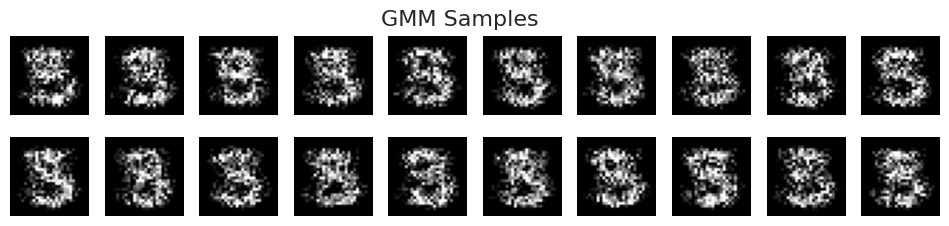

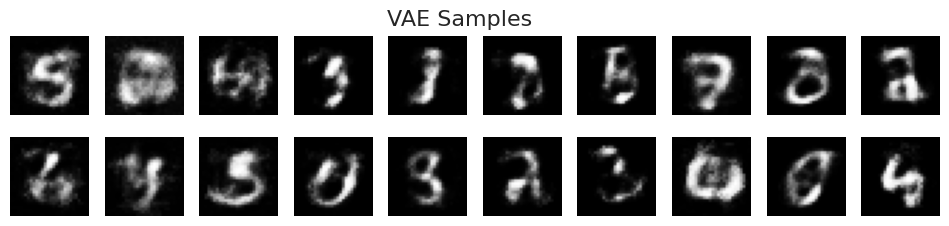

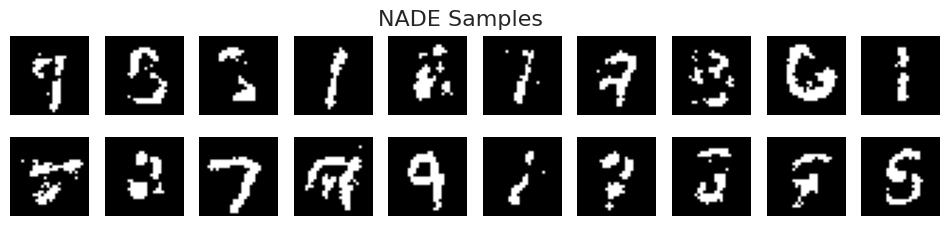

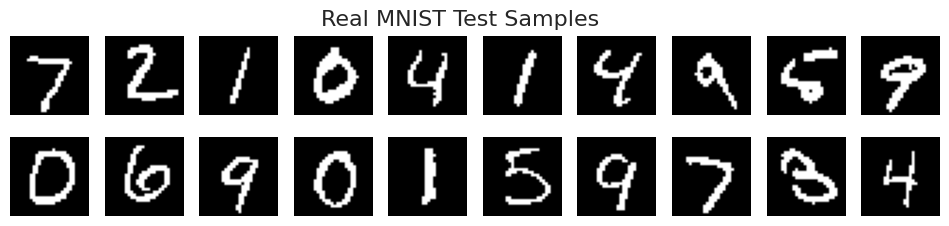

In [29]:
vae_model = VAE().to(device)
vae_model.load_state_dict(torch.load("vae_mnist.pth"))
vae_model.eval()

nade_model = NADE().to(device)
nade_model.load_state_dict(torch.load("nade_mnist.pth"))
nade_model.eval()

# Generate 1,000 samples from each model
torch.manual_seed(0)
with torch.no_grad():
    z = torch.randn(1000, vae_model.fc_mu.out_features).to(device)
    vae_samples = vae_model.decode(z).cpu().numpy()

    nade_samples = nade_model.sample(1000).cpu().numpy()


plot_samples(gmm_samples, "GMM Samples")

plot_samples(vae_samples, "VAE Samples")

plot_samples(nade_samples, "NADE Samples")

plot_samples(X_test_flat_binarized.cpu().numpy(), "Real MNIST Test Samples")

# Part 3: Sample Quality Metrics

- Which model scores best on each? Does this match your qualitative observations?

* FID : NADE hasd the lowest value, so NADE scores best.
* KID : NADE hasd the lowest value, so NADE scores best.
* IS : NADE has the greatest value, so NADE also scores best with this measure.

the GMM generated smaples are so unrecognizable, the VAE samples are so blury, and the NADE generated samples are much better just have some pixel noises, but overall the digits are recognizable.

i think the scores match the qualitative observations.

In [15]:

vae_features = get_features(vae_samples)
nade_features = get_features(nade_samples)
gmm_features = get_features(gmm_samples)


fid_vae = calculate_fid(real_features, vae_features)
fid_nade = calculate_fid(real_features, nade_features)
fid_gmm = calculate_fid(real_features, gmm_features)

kid_vae = calculate_kid(real_features, vae_features)
kid_nade = calculate_kid(real_features, nade_features)
kid_gmm = calculate_kid(real_features, gmm_features)

vae_probs = get_labels_and_probs(vae_samples)
nade_probs = get_labels_and_probs(nade_samples)
gmm_probs = get_labels_and_probs(gmm_samples)

is_vae, _, _ = calculate_is_and_diversity(vae_probs)
is_nade, _, _ = calculate_is_and_diversity(nade_probs)
is_gmm, _, _ = calculate_is_and_diversity(gmm_probs)

results = {
    "Metric": ["FID (↓)", "KID (x100) (↓)", "Inception Score (↑)"],
    "GMM": [f"{fid_gmm:.2f}", f"{kid_gmm*100:.2f}", f"{is_gmm:.2f}"],
    "VAE": [f"{fid_vae:.2f}", f"{kid_vae*100:.2f}", f"{is_vae:.2f}"],
    "NADE": [f"{fid_nade:.2f}", f"{kid_nade*100:.2f}", f"{is_nade:.2f}"],
}
df_results = pd.DataFrame(results)
print("--- Sample Quality Metrics ---")
print(df_results.to_string(index=False))

<ipython-input-6-4050176068>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = TensorDataset(torch.tensor(data).to(device))


--- Sample Quality Metrics ---
             Metric       GMM       VAE     NADE
            FID (↓)    401.98    259.18    60.95
     KID (x100) (↓) 306207.56 245164.70 39554.59
Inception Score (↑)      4.67      4.55     6.33


<ipython-input-6-4050176068>:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = TensorDataset(torch.tensor(data).to(device))


# Part 4: Diversity & Sparsity

- Does either model produce "conservative" digits (low diversity) or "risky" outliers?

i think risky means high sparsity adn noisy or blury pictures.
so as we can see from the diversity and sparsity values for each model:

we can say that VAE Diversity is higher than the others and its sparsity is lower than the other models. it means that this model generate vary samples and the more smooth and sharp digits.

in GMM diversity is low so we have more repetitive digits, the sparsity is higher than the other which shows the noisy and blury samples.
NADE is between them.


In [16]:
_, diversity_vae, sparsity_vae = calculate_is_and_diversity(vae_probs)
_, diversity_nade, sparsity_nade = calculate_is_and_diversity(nade_probs)
_, diversity_gmm, sparsity_gmm = calculate_is_and_diversity(gmm_probs)

div_results = {
    "Metric": ["Diversity (↑)", "Sparsity (↓)"],
    "GMM": [f"{diversity_gmm:.3f}", f"{sparsity_gmm:.3f}"],
    "VAE": [f"{diversity_vae:.3f}", f"{sparsity_vae:.3f}"],
    "NADE": [f"{diversity_nade:.3f}", f"{sparsity_nade:.3f}"],
}
df_div = pd.DataFrame(div_results)
print("--- Diversity and Sparsity Metrics ---")
print(df_div.to_string(index=False))

--- Diversity and Sparsity Metrics ---
       Metric   GMM   VAE  NADE
Diversity (↑) 2.111 2.235 2.212
 Sparsity (↓) 0.191 0.068 0.090


# Part 5: Compute NADE Log-Likelihood and VAE ELBO

- Why can’t we directly compare these values? What do they measure diﬀerently?

NADE computes the exact log-likelihood of the data under an autoregressive model. It gives a true estimate of how well the model fits the test data.
VAE, on the other hand, computes a variational lower bound (ELBO) on the log-likelihood. This is an approximation because the true posterior is intractable. ELBO includes a reconstruction term and a KL divergence term, and it's always lower than the true log-likelihood.
So they are different quantities , and we can't compare them directly.


In [17]:
nade_model.eval()
test_loss = 0
with torch.no_grad():
    logits = nade_model(X_test)

    test_loss = F.binary_cross_entropy_with_logits(logits, X_test, reduction='sum').item()

nll_bpd = (test_loss / len(X_test)) / (784 * np.log(2.))
print(f"NADE Test-set Negative Log-Likelihood: {nll_bpd:.4f} bits/dim")

vae_model.eval()
test_loss = 0
with torch.no_grad():
    for i, (data, _) in enumerate(test_loader):
        data = (data > 0.5).float().to(device)
        recon_batch, mu, logvar = vae_model(data)
        test_loss += vae_loss_function(recon_batch, data, mu, logvar).item()

elbo = -test_loss / len(test_loader.dataset)
print(f"VAE Test-set ELBO: {elbo:.4f}")

NADE Test-set Negative Log-Likelihood: 0.1805 bits/dim
VAE Test-set ELBO: -119.0895


# Part 6: Training Eﬃciency

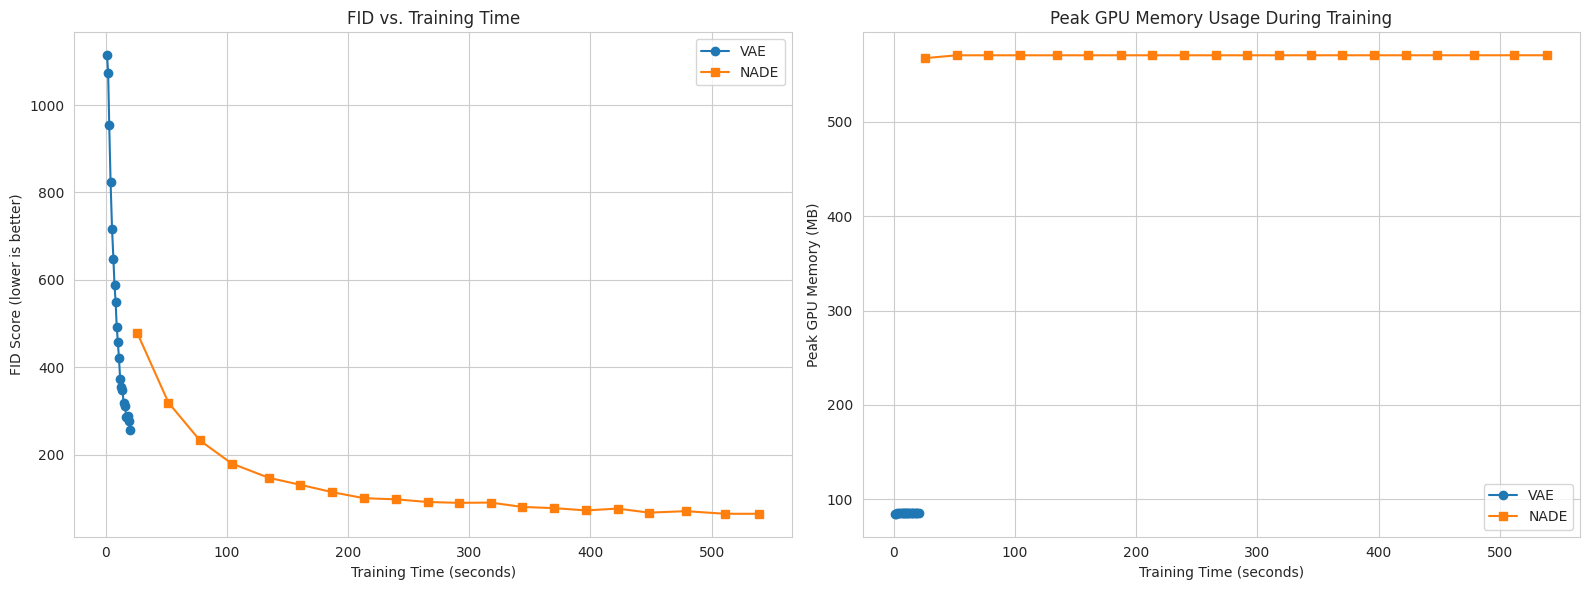

In [18]:

sns.set_style("whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax1 = axes[0]
ax1.plot(vae_history['time_sec'], vae_history['fid'], marker='o', linestyle='-', label='VAE')
ax1.plot(nade_history['time_sec'], nade_history['fid'], marker='s', linestyle='-', label='NADE')
ax1.set_xlabel("Training Time (seconds)")
ax1.set_ylabel("FID Score (lower is better)")
ax1.set_title("FID vs. Training Time")
ax1.legend()
ax1.grid(True)

ax2 = axes[1]
ax2.plot(vae_history['time_sec'], vae_history['peak_gpu_mem_mb'], marker='o', linestyle='-', label='VAE')
ax2.plot(nade_history['time_sec'], nade_history['peak_gpu_mem_mb'], marker='s', linestyle='-', label='NADE')
ax2.set_xlabel("Training Time (seconds)")
ax2.set_ylabel("Peak GPU Memory (MB)")
ax2.set_title("Peak GPU Memory Usage During Training")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

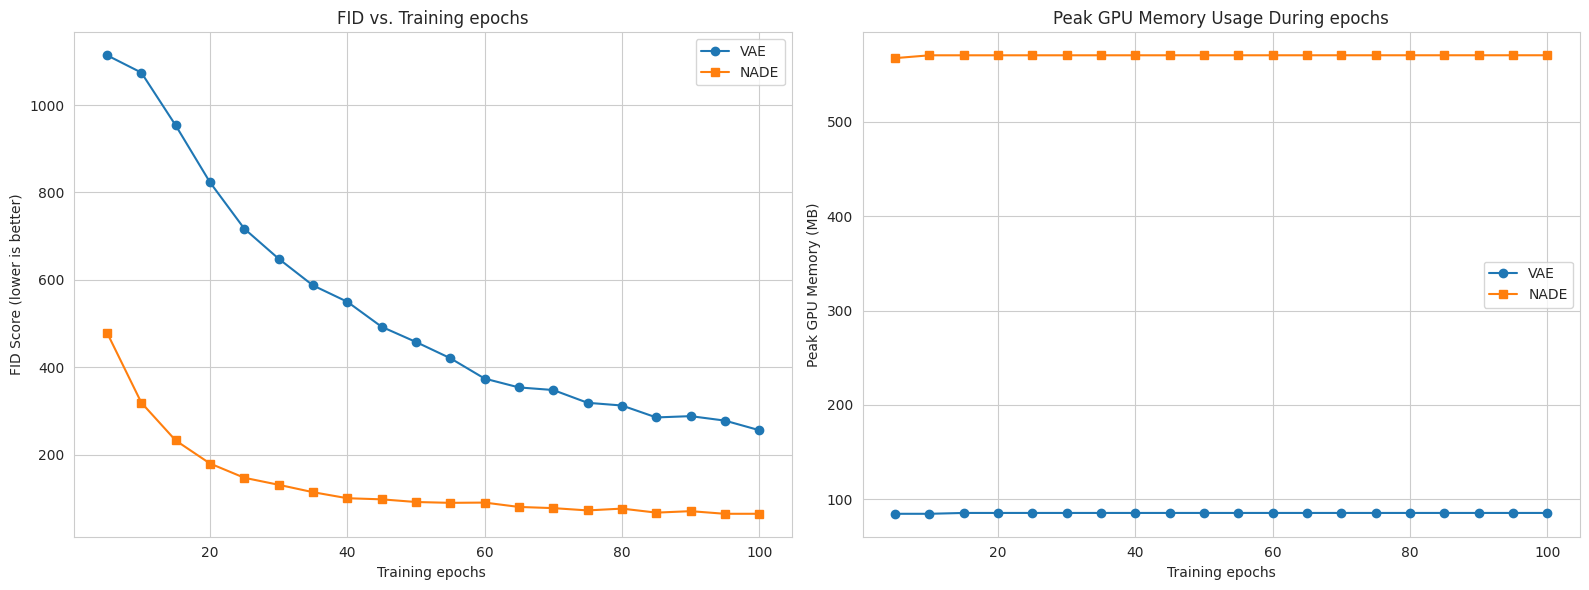

In [21]:

sns.set_style("whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax1 = axes[0]
ax1.plot(vae_history['epoch'], vae_history['fid'], marker='o', linestyle='-', label='VAE')
ax1.plot(nade_history['epoch'], nade_history['fid'], marker='s', linestyle='-', label='NADE')
ax1.set_xlabel("Training epochs ")
ax1.set_ylabel("FID Score (lower is better)")
ax1.set_title("FID vs. Training epochs")
ax1.legend()
ax1.grid(True)

ax2 = axes[1]
ax2.plot(vae_history['epoch'], vae_history['peak_gpu_mem_mb'], marker='o', linestyle='-', label='VAE')
ax2.plot(nade_history['epoch'], nade_history['peak_gpu_mem_mb'], marker='s', linestyle='-', label='NADE')
ax2.set_xlabel("Training epochs")
ax2.set_ylabel("Peak GPU Memory (MB)")
ax2.set_title("Peak GPU Memory Usage During epochs")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

- At what point does VAE converge vs. NADE?

VAE shows significant improvement up to about 60-70 epochs. After this point, the rate of improvement slows down considerably, and its FID score hovers around 300-270. 
NADE converges much faster to a low FID score. It reaches a relatively stable and much lower FID (below 100) by around 40-50 epochs, and continues to slowly refine down to an even lower score (around 60-70) by 100 epochs.

- Is more training always better?

For VAE, training beyond 70 epochs yields little benefit, so more training wastes computation without improving results.

For NADE, more training is beneficial, at least up to 100 epochs, since FID continues to decrease.



# Part 7: Measure Sampling Speed:


as we can see from the results the sampling time for NADE is greater than the others so its so slow and now the question is relevant.

NADE computes the probability (or reconstruction) of each pixel one at a time, conditioning on all previous pixels. VAE, on the other hand, can generate all pixels in one forward pass through a decoder.


Yes; caching can help, especially during training/log-prob computation.
The hidden layer activations h are recomputed for each pixel.
We can cache intermediate hidden activations or input masks if they are reused across multiple dimensions.




In [20]:

def time_sampling(model_name, gen_func, n_single=1, n_batch=100):
    start_time = time.time()
    gen_func(n_single)
    end_time = time.time()
    single_time = end_time - start_time

    start_time = time.time()
    gen_func(n_batch)
    end_time = time.time()
    batch_time = end_time - start_time

    return single_time, batch_time

def vae_gen(n):
    with torch.no_grad():
        z = torch.randn(n, 20).to(device)
        vae_model.decode(z)

def nade_gen(n):
    nade_model.sample(n)

def gmm_gen(n):
    gmm.sample(n)

vae_single, vae_batch = time_sampling("VAE", vae_gen)
nade_single, nade_batch = time_sampling("NADE", nade_gen)
gmm_single, gmm_batch = time_sampling("GMM", gmm_gen)

speed_results = {
    "Model": ["GMM", "VAE", "NADE"],
    "Time for 1 Sample (s)": [f"{gmm_single:.4f}", f"{vae_single:.4f}", f"{nade_single:.4f}"],
    "Time for 100 Samples (s)": [f"{gmm_batch:.4f}", f"{vae_batch:.4f}", f"{nade_batch:.4f}"],
}
df_speed = pd.DataFrame(speed_results)
print("--- Sampling Speed ---")
print(df_speed.to_string(index=False))

NADE Sampling:   0%|          | 0/784 [00:00<?, ?it/s]

NADE Sampling:   0%|          | 0/784 [00:00<?, ?it/s]

--- Sampling Speed ---
Model Time for 1 Sample (s) Time for 100 Samples (s)
  GMM                0.0008                   0.0044
  VAE                0.0032                   0.0004
 NADE                0.1556                   0.1758


# Part 8: Limitations & Ethics

- If NADE has better FID but VAE trains faster, which would you deploy on a mobile device?
VAE is better option because inference speed and computational cost matter far more than training time for deployment. NADE is slow at inference due to its sequential (autoregressive) sampling — it generates pixels one at a time.
VAE samples all pixels in parallel, making it much faster and more practical for real-time applications like image generation or augmentation on mobile.


- MNIST is grayscale and low-res—how might FID/KID mislead us on CIFAR-10?

FID/KID could be less reliable or misleading on CIFAR-10  because it may underestimate visual defects or fail to capture perceptual quality on complex datasets.

* FID/KID summarize statistics of features and do not directly measure perceptual fidelity or human judgment.
* Both FID and KID estimates can be noisy if computed on small sample sizes.(CIFAR-10 images are small (32x32))
*

- Could either model’s latent space leak private training data?

Yes, both VAE and NADE could potentially leak private training data, VAE has an explicit latent space, and if it overfits or memorizes data, reconstructions or interpolations could resemble actual training images.
NADE, while not having an explicit latent space, is autoregressive and models conditional probabilities. If overfitted, it might memorize patterns, especially rare ones, and generate high-fidelity reconstructions that resemble training samples.